# Reccomendation System for Steam Game - Collaborative Filtering

- Author    : Muhammad Aditya Bayhaqie
- Practice  : Machine Learning Terapan (Dicoding)
- Dataset   : [Steam Games Kaggle](https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data?select=games.csv)

## Data Understanding

Mari panggil library dan dataset yang akan digunakan.

In [ ]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download fronkongames/steam-games-dataset

In [ ]:
# !unzip steam-games-dataset.zip

### Data Assessment

In [ ]:
games = pd.read_csv('/content/games.csv')

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111452 entries, 20200 to 3183790
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AppID                       111446 non-null  object 
 1   Name                        111452 non-null  object 
 2   Release date                111452 non-null  object 
 3   Estimated owners            111452 non-null  int64  
 4   Peak CCU                    111452 non-null  int64  
 5   Required age                111452 non-null  float64
 6   Price                       111452 non-null  int64  
 7   DiscountDLC count           111452 non-null  int64  
 8   About the game              104969 non-null  object 
 9   Supported languages         111452 non-null  object 
 10  Full audio languages        111452 non-null  object 
 11  Reviews                     10624 non-null   object 
 12  Header image                111452 non-null  object 
 13  Website       

Dari data tersebut, ditarik kesimpulan bahwa:
- Terdapat 37 **Kolom**
- Terdapat 111452 **Baris**
- Beberapa Kolom memiliki **Non-null** yang sedikit (`Score rank`, `Metacritic url`, `Reviews`) dan perlu ditangani dengan beberapa metode berupa
  - Drop Kolom
  - Isi Kolom kosong

In [ ]:
# Membaca dataset

df = games
df.head(5)

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


Dari data tersebut, Dapat disimpulkan bahwa Terjadi pergeseran konten data dari kolom `AppID` hingga `DiscountDLCcount`, `AppID` akan di drop karena data tersebut Insignifikan dan Kolom lainnya akan direname untuk memperbaiki konten data

### Data Preparation

In [ ]:
# Rename columns
df = df.rename(columns={
    'Price': 'DiscountDLC count',
    'Required age' : 'Price',
    'Peak CCU': 'Required age',
    'Estimated owners': 'Peak CCU',
    'Release date': 'Estimated owners',
    'Name': 'Release date',
    'AppID': 'Name',
})

# Reindex the DataFrame
df = df.reset_index(drop=True)

df.head(5)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DiscountDLC count,DiscountDLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [ ]:
# Drop the 8th column ('DiscountDLC count')
df = df.drop(df.columns[7], axis=1)

# Display the updated DataFrame (optional)
df.head(5)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Reviews,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


## Exploratory Data Analysis

### Univariate Exploratory Data Analysis

`Game` Variable

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111452 entries, 0 to 111451
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Name                        111446 non-null  object 
 1   Release date                111452 non-null  object 
 2   Estimated owners            111452 non-null  object 
 3   Peak CCU                    111452 non-null  int64  
 4   Required age                111452 non-null  int64  
 5   Price                       111452 non-null  float64
 6   About the game              104969 non-null  object 
 7   Supported languages         111452 non-null  object 
 8   Full audio languages        111452 non-null  object 
 9   Reviews                     10624 non-null   object 
 10  Header image                111452 non-null  object 
 11  Website                     46458 non-null   object 
 12  Support url                 50759 non-null   object 
 13  Support email 

Fitur `Release date` perlu diganti tipe datanya ke dates agar datanya dapat meproses masukan data lebih baik nantinya

In [ ]:
print('Banyak data game yang terdaftar: ', len(df.Name.unique()))
print('Banyak game yang terdaftar: ', df.Name.unique())
print('List Game: ', df.Name.unique())

Banyak data game yang terdaftar:  110326
Banyak game yang terdaftar:  ['Galactic Bowling' 'Train Bandit' 'Jolt Project' ... 'MosGhost'
 'AccuBow VR' 'Defense Of Fort Burton']
List Game:  ['Galactic Bowling' 'Train Bandit' 'Jolt Project' ... 'MosGhost'
 'AccuBow VR' 'Defense Of Fort Burton']


Terdapat 110326 data Game yang unik dengan 37 Fitur yang dapat digunakan

## Data Preprocessing

## Data Preparation

### Taking care on Missing Values

In [ ]:
# Mengecek missing value pada dataframe all_resto
df.isnull().sum()

,0
Name,6
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,6483
Supported languages,0
Full audio languages,0
Reviews,100828


#### `Name` Feature Treatment

Feature `Name` yang null akan didrop saja barisnya.

In [ ]:
df.dropna(subset=['Name'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,6478
Supported languages,0
Full audio languages,0
Reviews,100822


#### `About the game` Feature Treatment

Feature `About the game` akan diganti dengan data

```
No Description
```

In [ ]:
df['About the game'] = df['About the game'].fillna('No Description')
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Reviews,100822


#### `Reviews`, `Website`, `Support url`, `Support email`, `Metacritic url`, `Score rank` and `Notes` Feature Treatment

Fitur `Reviews`, `Website`, `Support url`, `Support email`, `Metacritic url`, `Score rank` dan `Notes` akan didrop saja kolomnya

*PS: Data ini dapat digunakan sebagai pelengkap deskripsi game yang akan kita rekomendasikan, namun untuk kali ini datanya akan didrop saja*

In [ ]:
# Drop specified columns
columns_to_drop = ['Reviews', 'Website', 'Support url', 'Support email', 'Metacritic url', 'Score rank', 'Notes']
df = df.drop(columns=columns_to_drop)

df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Developers` Feature Treatment

Feature `Developers` yang null akan didrop saja barisnya.

In [ ]:
df.dropna(subset=['Developers'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Publishers` Feature Treatment

Feature `Publishers` yang null akan kita samakan dengan developers

In [ ]:
publishers_with_null = df[df['Publishers'].isnull()]
print("Publishers with null data:")
display(publishers_with_null[['Name','Developers', 'Publishers']])

Publishers with null data:


,Name,Developers,Publishers
23,Turtle Lu,Falco Software,NaN
345,Borderless Gaming,"AndrewMD5,Codeusa",NaN
515,Bunker Constructor,Tindalos Interactive,NaN
659,Super Meat Boy,Team Meat,NaN
748,Little Square Things,G.Reed,NaN
...,...,...,...
99688,AnderKant,KlankeKlanke,NaN
101299,Ancient Ruins,Byking Inc,NaN
101396,Heritage - A Dragon's Tale,CGWorks_HeritageDev,NaN
102415,Retail Mage,Jam & Tea Studios,NaN


In [ ]:
df['Publishers'].fillna(df['Developers'], inplace=True)
df.isnull().sum()

<ipython-input-80-bd2c90a00109>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Publishers'].fillna(df['Developers'], inplace=True)


,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Categories` Feature Treatment

In [ ]:
display(df.head())

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Header image,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [ ]:
display(df[df['Categories'].isnull()])

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Header image,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
31,Home Office Tasker,"Sep 8, 2021",0 - 20000,0,0,0.99,You no longer need to go to special applicatio...,"['English', 'Russian', 'German', 'Spanish - Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,lonch.me,lonch.me,NaN,Utilities,"Utilities,Time Management,Time Manipulation,So...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
145,Kooring VR Coding Adventure,Aug 2020,0 - 20000,0,0,8.49,Help Kooring get to the goal through the 3 dif...,"['English', 'Simplified Chinese', 'Korean', 'T...","['English', 'Simplified Chinese', 'Korean', 'T...",https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,VRANI inc.,VRANI inc.,NaN,"Adventure,Casual,Indie,Strategy,Education","Education,Choose Your Own Adventure,Programmin...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
216,Maria Blanchard Virtual Gallery,"Jul 1, 2022",0 - 0,0,0,0.00,Maria Blanchard (1881-1932). She was a Franco-...,['Spanish - Spain'],['Spanish - Spain'],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Virtual Video,Virtual Video,NaN,"Design & Illustration,Education",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
359,Gamefuel Driver Control,"Dec 10, 2015",20000 - 50000,0,0,29.99,The problem: You may have hardware or devices ...,['English'],[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,0,0,Auslogics Software,Console Classics,NaN,Utilities,Utilities,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
450,Start10,"May 11, 2017",0 - 20000,0,0,4.99,Customize your Start menu for easy access to U...,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://cdn.akamai.steamstatic.com/steam/apps/...,...,0,1,0,Stardock,Stardock,NaN,Utilities,"Utilities,Software",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110841,Desktop Lux,"Mar 23, 2025",0 - 20000,0,0,9.99,Desktop Lux is a program for decoration and ad...,"['English', 'Russian', 'Simplified Chinese']","['English', 'Russian', 'Simplified Chinese']",https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,Pothos,Pothos,NaN,"Animation & Modeling,Design & Illustration,Uti...",NaN,https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
110899,Image2pixel-PixelArtGenerator,"Mar 14, 2025",0 - 20000,2,0,9.99,Image2pixel is a pixel painting generation too...,"['English', 'French', 'Italian', 'German', 'Sp...",[],https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,PixelBearStudio,PixelBearStudio,NaN,"Design & Illustration,Photo Editing","Photo Editing,Design & Illustration",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111118,MateEngine,"Apr 16, 2025",0 - 20000,59,0,3.99,"MateEngine MateEngine is a lightweight, custom...","['English', 'Spanish - Spain', 'Japanese', 'Ru...","['English', 'Japanese', 'Traditional Chinese']",https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,Shinyflvres,Shinymoon,NaN,"Animation & Modeling,Design & Illustration","Animation & Modeling,Design & Illustration,Anime",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
111243,JWildfireSwan,"Mar 13, 2025",0 - 20000,1,0,24.99,"JWildfireSwan is the successor to JWildfire, a...",['English'],[],https://shared.akamai.steamstatic.com/store_it...,...,0,0,0,Andreas Maschke,Andreas Maschke,NaN,"Animation & Modeling,Design & Illustration,Gam

Data null pada `Categories` akan kita drop saja

In [ ]:
df.dropna(subset=['Categories'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Header image,0


#### `Screenshots` , `Movies` and `Header image` Feature Treatment

Untuk fitur `Screenshots` and `Movies` akan didrop saja karena tidak relevan untuk keperluan sistem rekomendasi nantinya

*PS: Data ini dapat digunakan sebagai pelengkap deskripsi game yang akan kita rekomendasikan, namun untuk kali ini datanya akan didrop saja*

In [ ]:
# Drop specified columns
columns_to_drop = ['Screenshots', 'Movies', 'Header image']
df = df.drop(columns=columns_to_drop)

df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Windows,0


#### `Genres` Feature Treatment

Untuk fitur `Genres` akan didrop karena jumlah data Null yang sedikit

In [ ]:
df.dropna(subset=['Genres'], inplace=True)
df.isnull().sum()

,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Windows,0


#### `Tags` Feature Treatment

Untuk fitur `Tags` akan diisi dengan data pada `Genres`

In [ ]:
df['Tags'].fillna(df['Genres'], inplace=True)
df.isnull().sum()

<ipython-input-86-bb46694dce1f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tags'].fillna(df['Genres'], inplace=True)


,0
Name,0
Release date,0
Estimated owners,0
Peak CCU,0
Required age,0
Price,0
About the game,0
Supported languages,0
Full audio languages,0
Windows,0


### Data Type Modification

In [ ]:
# Change 'Release date' to datetime
df['Release date'] = pd.to_datetime(df['Release date'], format='%b %d, %Y', errors='coerce')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 103573 entries, 0 to 111451
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Name                        103573 non-null  object        
 1   Release date                103448 non-null  datetime64[ns]
 2   Estimated owners            103573 non-null  object        
 3   Peak CCU                    103573 non-null  int64         
 4   Required age                103573 non-null  int64         
 5   Price                       103573 non-null  float64       
 6   About the game              103573 non-null  object        
 7   Supported languages         103573 non-null  object        
 8   Full audio languages        103573 non-null  object        
 9   Windows                     103573 non-null  bool          
 10  Mac                         103573 non-null  bool          
 11  Linux                       103573 non-null 

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],True,...,0,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],True,...,0,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


In [ ]:
display(df)

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],[],True,...,0,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],True,...,0,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111447,Paragon Of Time,2025-04-10,0 - 20000,0,0,2.99,"You stand at the edge of time, trying to save ...",['English'],[],True,...,0,0,0,0,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
111448,A Few Days With : Hazel,2025-04-11,0 - 20000,0,0,2.69,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",[],True,...,0,0,0,0,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie","Casual,Indie"
111449,MosGhost,2025-04-01,0 - 20000,0,0,7.99,Story : Andrei moved to Moscow for work and re...,"['English', 'Russian', 'French', 'Italian', 'G...",[],True,...,0,0,0,0,0,Sinka Games,"Sinka Games,Arkuda Inc.","Single-player,Family Sharing",Simulation,"Simulation,Walking Simulator,Idler,First-Perso..."
111450,AccuBow VR,2025-03-11,0 - 0,0,0,0.00,AccuBow VR: Master Realistic Archery in Immers...,['English'],['English'],True,...,0,0,0,0,0,AccuBow LLC,AccuBow LLC,"Single-player,Tracked Controller Support,VR On...","Action,Adventure,Free To Play","Action,Adventure,Free To Play"


### Value Modification

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103573 entries, 0 to 111451
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Name                        103573 non-null  object 
 1   Release date                103573 non-null  object 
 2   Estimated owners            103573 non-null  object 
 3   Peak CCU                    103573 non-null  int64  
 4   Required age                103573 non-null  int64  
 5   Price                       103573 non-null  float64
 6   About the game              103573 non-null  object 
 7   Supported languages         103573 non-null  object 
 8   Full audio languages        103573 non-null  object 
 9   Windows                     103573 non-null  bool   
 10  Mac                         103573 non-null  bool   
 11  Linux                       103573 non-null  bool   
 12  Metacritic score            103573 non-null  int64  
 13  User score         

#### Data Modification on `Supported languages` and `Full audio languages`

Data yang mengandung

```
[]
```

Pada `Supported languages` dan `Full audio languages` akan diganti dengan

```
No Supporting Languages / No Full audio languages
```

In [ ]:
# Function to check and replace empty lists, and count occurrences
def replace_empty_lists_and_count(df, column_name):
  empty_list_count = 0
  for index, value in df[column_name].items():
    if value == '[]':
      df.loc[index, column_name] = f'No {column_name}'
      empty_list_count += 1
  return df, empty_list_count

# Process 'Supported languages' column
df, supported_languages_count = replace_empty_lists_and_count(df, 'Supported languages')
print(f"Number of entries with '[]' in 'Supported languages': {supported_languages_count}")

# Process 'Full audio languages' column
df, full_audio_languages_count = replace_empty_lists_and_count(df, 'Full audio languages')
print(f"Number of entries with '[]' in 'Full audio languages': {full_audio_languages_count}")

# Display rows that originally contained '[]' in either column (now replaced)
display(df[
    (df['Supported languages'] == 'No Supported languages') |
    (df['Full audio languages'] == 'No Full audio languages')
])

Number of entries with '[]' in 'Supported languages': 82
Number of entries with '[]' in 'Full audio languages': 58402


,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],No Full audio languages,True,...,0,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",No Full audio languages,True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",No Full audio languages,True,...,0,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111444,Kafkaesque: The Nightmare Trial,2025-04-17,0 - 20000,0,0,2.39,Kafkaesque: The Nightmare Trial is a psycholog...,['English'],No Full audio languages,True,...,0,0,0,0,0,Dawn Fades,Dawn Fades,"Single-player,Steam Achievements,Full controll...","Action,Indie","Action,Indie"
111446,Starry Trace,2025-04-14,0 - 20000,0,0,1.21,Welcome to Starry Trace ! A relaxing yet brain...,"['English', 'Japanese', 'Simplified Chinese', ...",No Full audio languages,True,...,0,0,0,0,0,Pomegranate Games,Pomegranate Games,"Single-player,Steam Achievements,Full controll...","Casual,Indie,Strategy","Casual,Strategy,Puzzle,Relaxing,2D,Cute,Detect..."
111447,Paragon Of Time,2025-04-10,0 - 20000,0,0,2.99,"You stand at the edge of time, trying to save ...",['English'],No Full audio languages,True,...,0,0,0,0,0,Webcess,Webcess,"Single-player,Full controller support,Steam Cl...","Action,Casual,Indie","Action Roguelike,Bullet Hell,Hack and Slash,Ro..."
111448,A Few Days With : Hazel,2025-04-11,0 - 20000,0,0,2.69,"Join Hazel, an attractive young lady, and enjo...","['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,0,0,0,0,Hentai Panda,Hentai Panda,"Single-player,Steam Achievements,Steam Cloud,F...","Casual,Indie","Casual,Indie"


In [92]:
df.head()

,Name,Release date,Estimated owners,Peak CCU,Required age,Price,About the game,Supported languages,Full audio languages,Windows,...,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags
0,Galactic Bowling,2008-10-21,0 - 20000,0,0,19.99,Galactic Bowling is an exaggerated and stylize...,['English'],No Full audio languages,True,...,0,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling"
1,Train Bandit,2017-10-12,0 - 20000,0,0,0.99,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc..."
2,Jolt Project,2021-11-17,0 - 20000,0,0,4.99,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",No Full audio languages,True,...,0,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy","Action,Adventure,Indie,Strategy"
3,Henosis™,2020-07-23,0 - 20000,0,0,5.99,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",No Full audio languages,True,...,0,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz..."
4,Two Weeks in Painland,2020-02-03,0 - 20000,0,0,0.00,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",No Full audio languages,True,...,0,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,..."


### Feature Consideration

### Dropping Duplicates

In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('placeID')
preparation

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
854,U1092,132572,1,0,0,Cafe Chaires,Cafeteria
27,U1044,132583,1,2,1,McDonalds Centro,American
148,U1063,132584,2,1,1,Gorditas Dona Tota,Mexican
1304,U1087,132594,1,2,1,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...,...,...,...,...
1016,U1019,135086,0,0,0,Mcdonalds Parque Tangamanga,Burgers
179,U1051,135088,1,1,1,Cafeteria cenidet,Cafeteria
4,U1068,135104,1,1,2,vips,Mexican
807,U1135,135106,0,0,0,El Rincón de San Francisco,Mexican


### Data Conversion

In [ ]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
resto_id = preparation['placeID'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
resto_name = preparation['name'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
resto_cuisine = preparation['Rcuisine'].tolist()

print(len(resto_id))
print(len(resto_name))
print(len(resto_cuisine))

95
95
95


### Dictionary Making

Kita akan membuat dictionary untuk menentukan pasangan key-value pada data resto_id, resto_name, dan resto_cuisine yang telah kita siapkan sebelumnya.

In [ ]:
# Membuat dictionary untuk data ‘resto_id’, ‘resto_name’, dan ‘cuisine’
resto_new = pd.DataFrame({
    'id': resto_id,
    'resto_name': resto_name,
    'cuisine': resto_cuisine
})
resto_new

,id,resto_name,cuisine
0,132560,puesto de gorditas,Regional
1,132572,Cafe Chaires,Cafeteria
2,132583,McDonalds Centro,American
3,132584,Gorditas Dona Tota,Mexican
4,132594,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...
90,135086,Mcdonalds Parque Tangamanga,Burgers
91,135088,Cafeteria cenidet,Cafeteria
92,135104,vips,Mexican
93,135106,El Rincón de San Francisco,Mexican


### Data Splitting

In [ ]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userID,placeID,rating,food_rating,service_rating,user,resto
538,U1052,132870,1.0,1,1,63,116
673,U1015,132869,2.0,2,2,11,115
578,U1047,132875,0.0,0,0,78,117
242,U1056,135076,2.0,2,2,41,71
1063,U1002,135106,1.0,1,1,125,64
...,...,...,...,...,...,...,...
1044,U1073,135065,0.0,0,0,123,94
1095,U1058,135062,2.0,2,2,124,76
1130,U1087,132660,1.0,1,0,132,14
860,U1029,132937,1.0,1,1,110,126


In [ ]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user', 'resto']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 63 116]
 [ 11 115]
 [ 78 117]
 ...
 [132  14]
 [110 126]
 [129   6]] [0.5 1.  0.  ... 0.5 0.5 0. ]


## Model Development using Collaborative Filtering

Pada tahap ini, model menghitung skor kecocokan antara pengguna dan resto dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan resto. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan resto. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan resto. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Next up, let's Compile!

In [ ]:
model = RecommenderNet(num_users, num_resto, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Let the training begin!

In [ ]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.6972 - root_mean_squared_error: 0.3912 - val_loss: 0.6969 - val_root_mean_squared_error: 0.4034
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6875 - root_mean_squared_error: 0.3950 - val_loss: 0.6931 - val_root_mean_squared_error: 0.4011
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6571 - root_mean_squared_error: 0.3837 - val_loss: 0.6894 - val_root_mean_squared_error: 0.3988
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6549 - root_mean_squared_error: 0.3734 - val_loss: 0.6832 - val_root_mean_squared_error: 0.3949
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6479 - root_mean_squared_error: 0.3711 - val_loss: 0.6812 - val_root_mean_squared_error: 0.3938
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6389 - root_mean_squared_error: 0.3617 - val_loss: 0.6795 - val_root_mean_squared_error: 0.3927
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 1

Mari kita visualisasikan datanya!

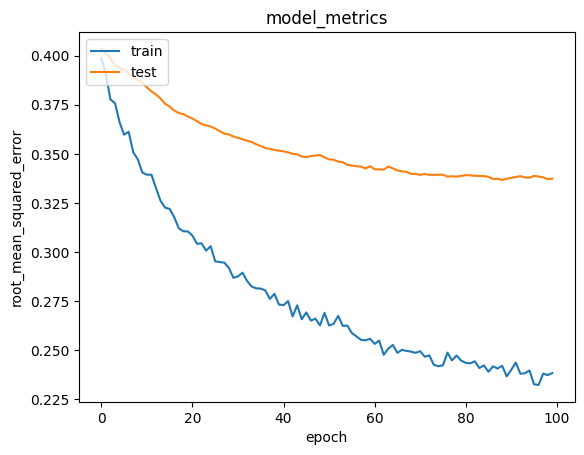

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Untuk mendapatkan rekomendasi resto, pertama kita ambil sampel user secara acak dan definisikan variabel resto_not_visited yang merupakan daftar resto yang belum pernah dikunjungi oleh pengguna.

In [ ]:
resto_df = resto_new
df = pd.read_csv('rating_final.csv')

# Mengambil sample user
user_id = df.userID.sample(1).iloc[0]
resto_visited_by_user = df[df.userID == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
resto_not_visited = resto_df[~resto_df['id'].isin(resto_visited_by_user.placeID.values)]['id']
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_encoded.keys()))
)

resto_not_visited = [[resto_to_resto_encoded.get(x)] for x in resto_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(resto_not_visited), resto_not_visited)
)

In [ ]:
ratings = model.predict(user_resto_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto.get(resto_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)

top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .placeID.values
)

resto_df_rows = resto_df[resto_df['id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.resto_name, ':', row.cuisine)

print('----' * 8)
print('Top 10 resto recommendation')
print('----' * 8)

recommended_resto = resto_df[resto_df['id'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    print(row.resto_name, ':', row.cuisine)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step
Showing recommendations for users: U1082
Resto with high ratings from user
--------------------------------
tacos de barbacoa enfrente del Tec : Mexican
Hamburguesas La perica : Mexican
Pollo_Frito_Buenos_Aires : Fast_Food
carnitas_mata : Mexican
palomo tec : Mexican
--------------------------------
Top 10 resto recommendation
--------------------------------
La Estrella de Dimas : Mexican
cafe punta del cielo : Cafeteria
rockabilly  : Bar
emilianos : Bar_Pub_Brewery
Restaurant Las Mananitas : International
Kiku Cuernavaca : Japanese
El Oceano Dorado : Mexican
El Rincon de San Francisco : Mexican
Preambulo Wifi Zone Cafe : Cafeteria
Michiko Restaurant Japones : Japanese
